In [33]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from linear_sca import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

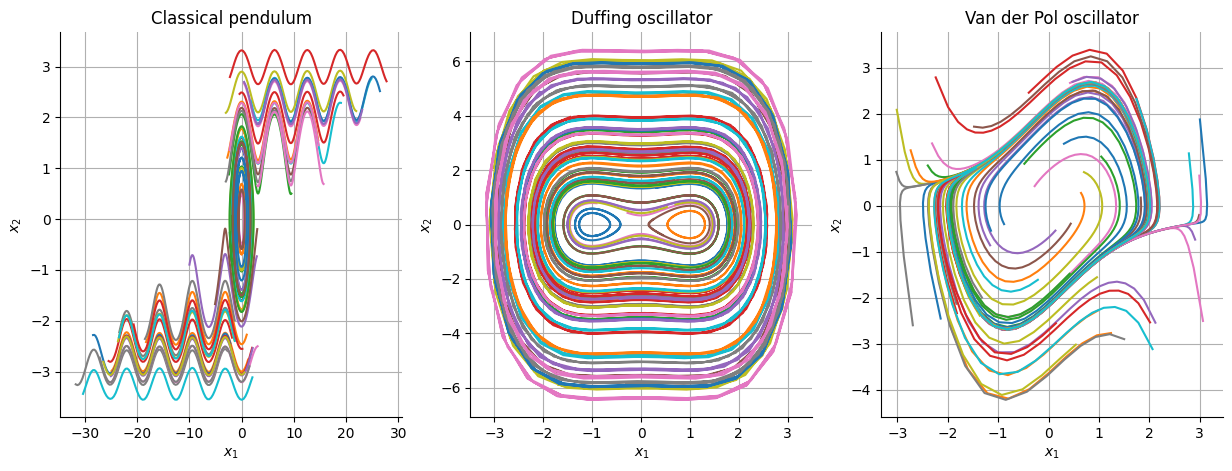

In [4]:
def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = -np.sin(x1)
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = x1 - x1**3
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = (1 - x1**2) * x2 - x1
    return [dx1_dt, dx2_dt]



t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 100)     # time points where the solution is computed


num_trajectories = 50

np.random.seed(0) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(pendulum_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[0].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[0].set_title('Classical pendulum')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(duffing_oscillator, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[1].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[1].set_title('Duffing oscillator')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[2].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[2].set_title('Van der Pol oscillator')

for ax in axs:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.grid()
    ax.spines[['right', 'top']].set_visible(False)


In [32]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2

In [6]:
X = jnp.array(X) 
optimized_params, ls_loss = optimize_U(X[10:], d=2, iterations=1000)  

Iteration 0, S: 741.2645874023438
Iteration 10, S: 1179.17431640625
Iteration 20, S: 581.6141967773438
Iteration 30, S: 1363.62451171875
Iteration 40, S: 1033.6455078125
Iteration 50, S: 1321.3895263671875
Iteration 60, S: 986.5537109375
Iteration 70, S: 882.0525512695312
Iteration 80, S: 1415.287841796875
Iteration 90, S: 1365.2725830078125
Iteration 100, S: 1021.07421875
Iteration 110, S: 666.4129028320312
Iteration 120, S: 1153.651123046875
Iteration 130, S: 1043.0943603515625
Iteration 140, S: 799.4598999023438
Iteration 150, S: 861.6498413085938
Iteration 160, S: 936.4243774414062
Iteration 170, S: 1376.801025390625
Iteration 180, S: 815.2154541015625
Iteration 190, S: 932.4119262695312
Iteration 200, S: 902.4913330078125
Iteration 210, S: 633.178955078125
Iteration 220, S: 1165.218994140625
Iteration 230, S: 1423.1295166015625
Iteration 240, S: 1431.258544921875
Iteration 250, S: 1583.801513671875
Iteration 260, S: 1154.755859375
Iteration 270, S: 1655.0184326171875
Iteration 280

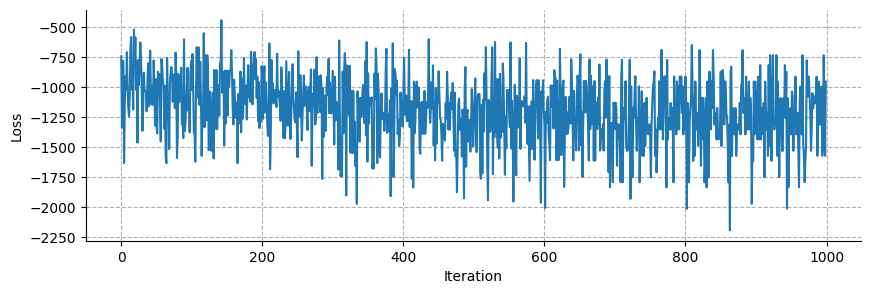

In [112]:
plt.figure(figsize=(10,3))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


In [7]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_params)        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde[:,:], X[:10])         #(K,d,T) 

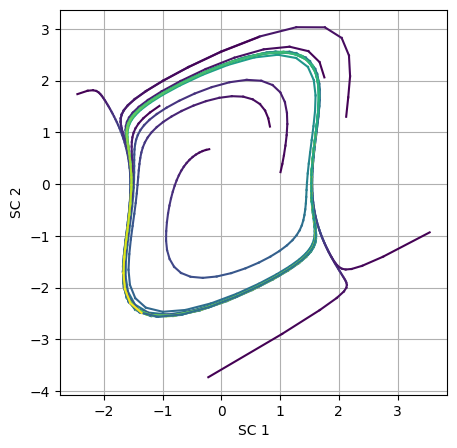

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0, Y.shape[0], 1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)))

ax.set_xlabel('SC 1')
ax.set_ylabel('SC 2')
plt.grid()

In [ ]:
#PCA 
X_reshaped = X.reshape(num_trajectories * len(t_eval), -1)

pca = PCA(n_components=2)
pca.fit(X_reshaped)
PCs = pca.components_

loadings = pca.transform(X_reshaped)
loadings = loadings.reshape(num_trajectories, 2, len(t_eval))